# Visualizing Radon Analysis (`.ipynb`)
## Radon Analysis Blinking
### Import necessary libraries

In [1]:
from src.radon_analyser import RadonAnalyzer
import mrcfile
import numpy as np
import matplotlib.pyplot as plt

### Set the paramters

In [2]:
templates_selected_mrcfile = './db/templates_selected.mrc'
section = 2
crop_rate = 0.7
threshold = 0.6
theta_start = 0
theta_end = 180

### Show the 2D average to be processed

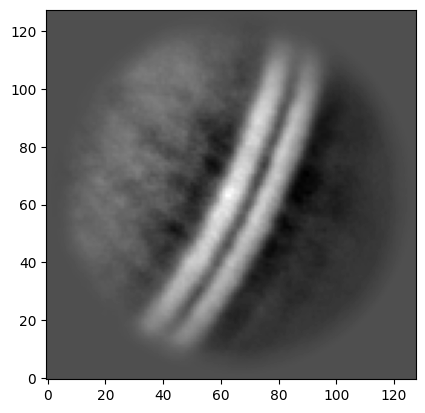

In [3]:
with mrcfile.open(templates_selected_mrcfile) as mrc:
    average2D = mrc.data[section]

plt.imshow(average2D, cmap='gray', origin='lower')

### Radon Analysis

peaks: (array([53, 65]), array([24, 24]))
point1: 53, 24; point2: 65, 24
average_theta: 24.0
membrane_distance: 12.0
b: 0.40673664307580015


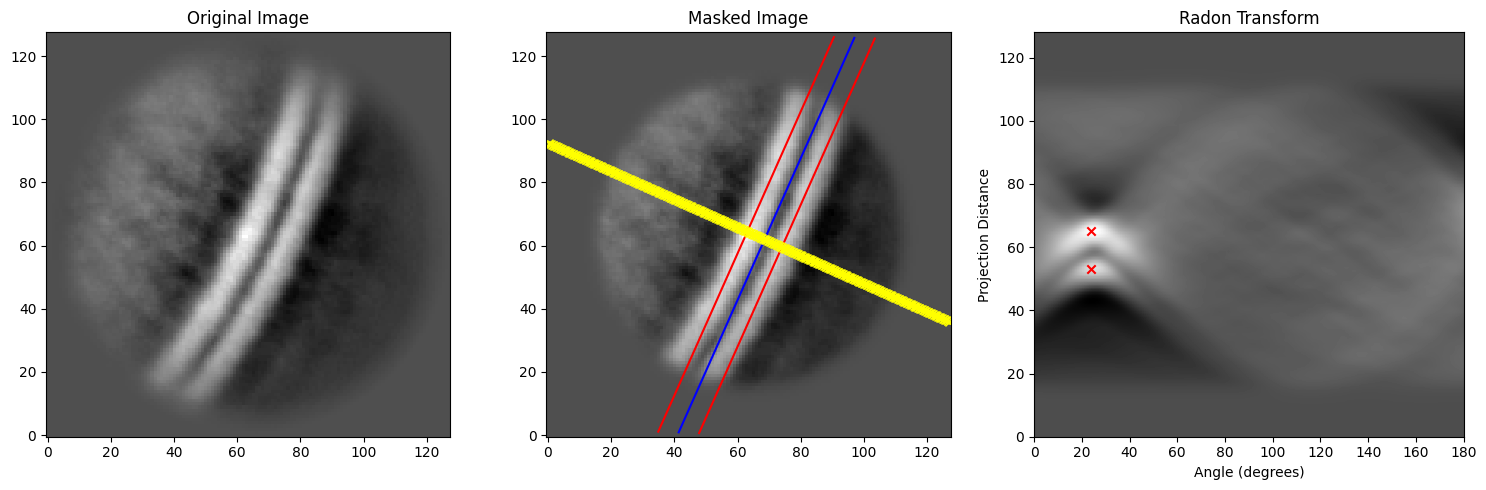

====Radon Analysis Results====
average_theta: 24.0
membrane_distance: 12.0


In [4]:
analyzer = RadonAnalyzer(average2D, crop_rate = crop_rate, thr = threshold, theta_start = theta_start, theta_end = theta_end)
analyzer.visualize_analyze()
rlnAngleTheta, rlnMembraneDistance = analyzer.return_results()

## Membrane Analysis

### Import necessary libraries

In [5]:
from src.template_centerfitting import *
from src.generate_gaussian_template import *
from src.calculate_curve import *
from src.generate_membrane_mask import *
from src.mem_average import *

### Set the paramters

In [6]:
# Fit membrane center
template_size = 32
theta = rlnAngleTheta
membrane_distance = rlnMembraneDistance
initial_sigma1 = 3
initial_sigma2 = 3
sigma_range = 3
sigma_step = 0.5
# Curve fitting
kappa_start = -0.01
kappa_end = 0.01
kappa_step = 0.001
# Generate membrane mask
edge_sigma_mask = 3
# Generate Membrane Average
extra_mem_dist = 15
edge_sigma = 5

### Generate the membrane template and search for the center

====Center fitting results====
membrane center y: 61.7459764590515
membrane center x: 69.06261976221613


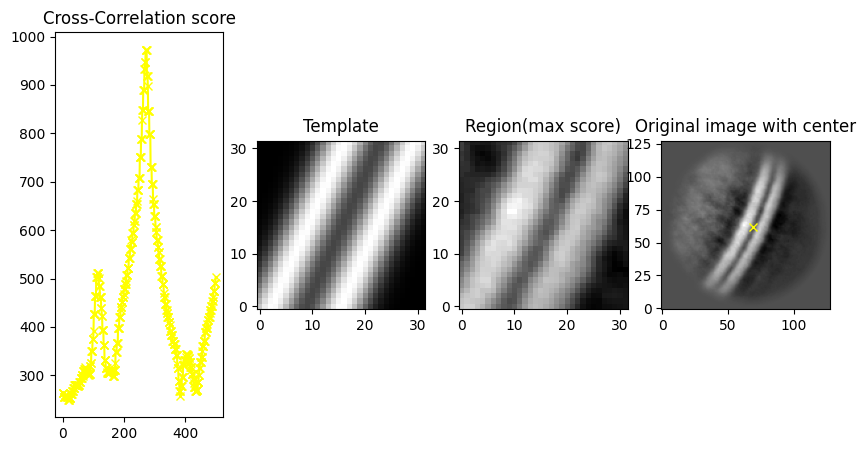

In [7]:
template_center_fitter = Template_centerfitting(sigma1 = initial_sigma1, sigma2 = initial_sigma2, image = average2D, crop_rate = crop_rate, thr = threshold, theta_start = theta_start, theta_end = theta_end, template_size = template_size, sigma_range = sigma_range, sigma_step = sigma_step)
rlnCenterX, rlnCenterY = template_center_fitter.centerfinder()
template_center_fitter.visualize_center()

### Search for the best sigma values

====Sigma fitting results====
best sigma1: 3.2411764705882358
best sigma2: 4.811764705882353


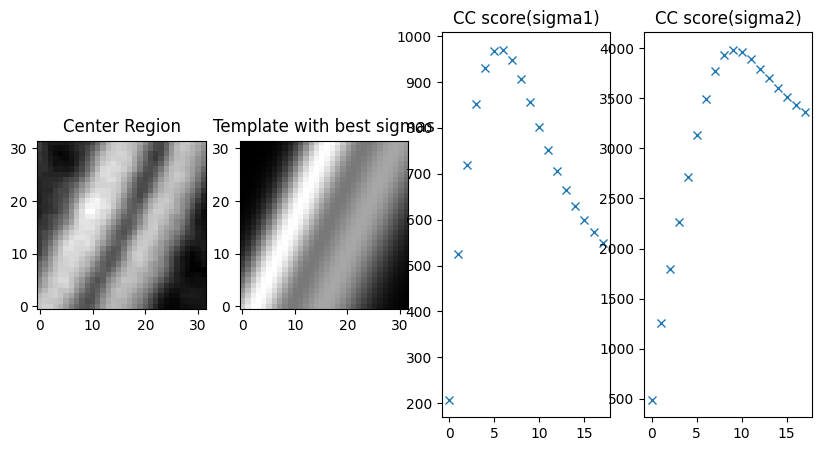

In [8]:
rlnSigma1, rlnSigma2 = template_center_fitter.fit_sigma()
template_center_fitter.fit_sigma_visualize()

### Generate simulated membrane

Text(0.5, 1.0, 'Simulated Membrane(kappa=0.005)')

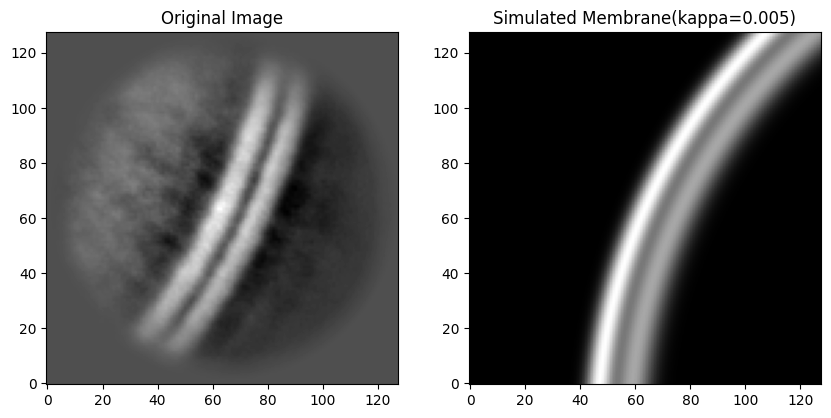

In [9]:
test_kappa = 0.005

curve_fitting = Curvefitting(image=average2D, kappa_start=kappa_start, kappa_end=kappa_end, kappa_step=kappa_step, 
                             rlnCenterX=rlnCenterX, rlnCenterY=rlnCenterY, rlnAngleTheta=rlnAngleTheta, 
                             rlnMembraneDistance=rlnMembraneDistance, rlnSigma1=rlnSigma1, rlnSigma2=rlnSigma2)

simulated_membrane_example = curve_fitting.generate_membrane(test_kappa)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(average2D, cmap='gray', origin='lower')
axes[0].set_title('Original Image')
axes[1].imshow(simulated_membrane_example, cmap='gray', origin='lower')
axes[1].set_title(f'Simulated Membrane(kappa={test_kappa})')

### Fit the curvature(Find the best kappa value)

Start curve fitting...
iter0 finished, kappa: -0.01, corr_score: 9479.32776779441
iter1 finished, kappa: -0.009000000000000001, corr_score: 9731.191886362822
iter2 finished, kappa: -0.008, corr_score: 9968.630910241023
iter3 finished, kappa: -0.007, corr_score: 10240.63445077838
iter4 finished, kappa: -0.006, corr_score: 10514.981483520773
iter5 finished, kappa: -0.005, corr_score: 10688.19001565214
iter6 finished, kappa: -0.004, corr_score: 10771.952027747464
iter7 finished, kappa: -0.003, corr_score: 10752.109321767228
iter8 finished, kappa: -0.002, corr_score: 10649.384406524576
iter9 finished, kappa: -0.0009999999999999992, corr_score: 10481.668865448042
iter10 finished, kappa: 0.0, corr_score: 10252.573673363295
iter11 finished, kappa: 0.0009999999999999992, corr_score: 9977.881574248659
iter12 finished, kappa: 0.002, corr_score: 9675.908790190737
iter13 finished, kappa: 0.003000000000000001, corr_score: 9337.255998829844
iter14 finished, kappa: 0.004, corr_score: 8996.65007898359

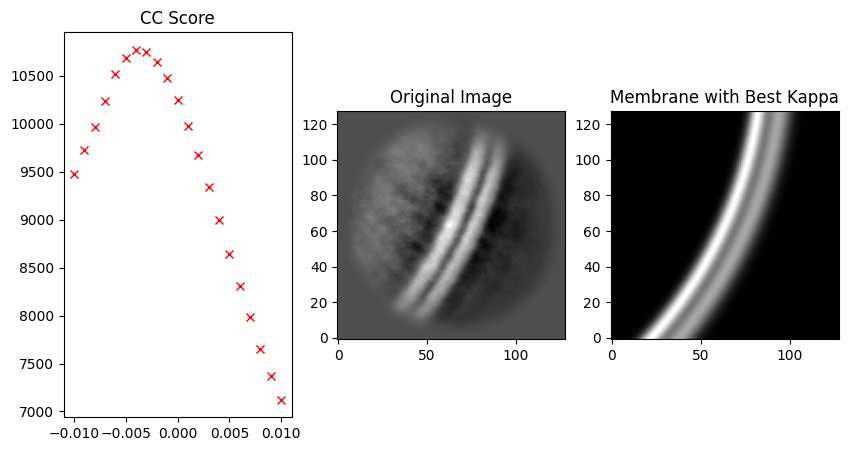

In [10]:
rlnCurveKappa = curve_fitting.fit_curve()
curve_fitting.fit_curve_visualize()

### Generate Membrane Mask

Text(0.5, 1.0, 'Membrane Masked Image')

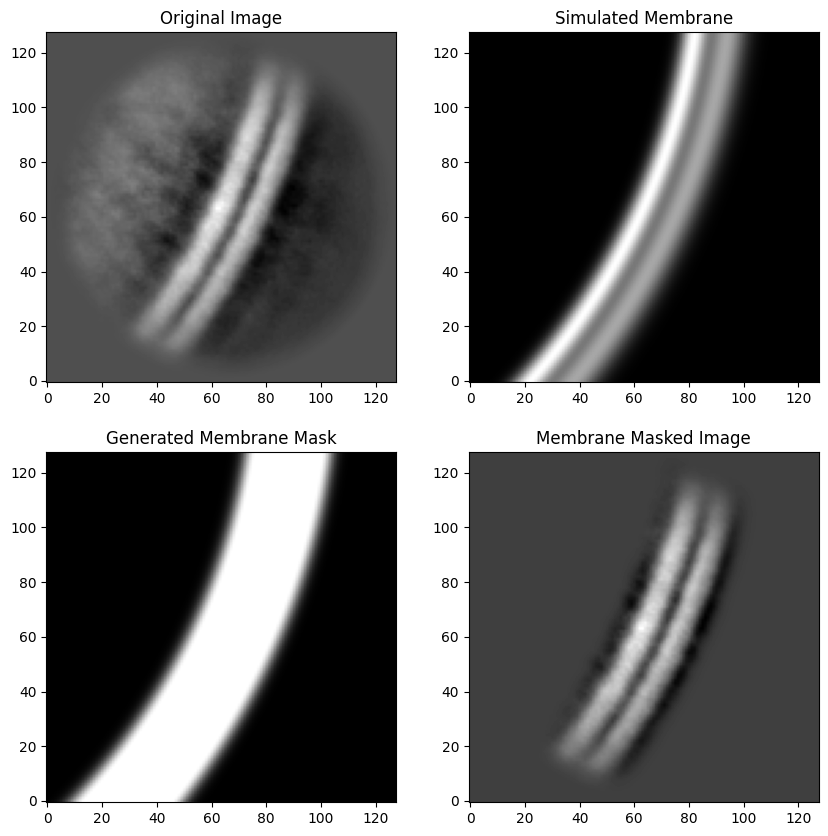

In [11]:
mem_mask_generator = mem_mask(image=average2D, rlnCenterX=rlnCenterX, rlnCenterY=rlnCenterY, rlnAngleTheta=rlnAngleTheta, 
                              rlnMembraneDistance=rlnMembraneDistance, rlnSigma1=rlnSigma1, rlnSigma2=rlnSigma2, 
                              rlnCurveKappa=rlnCurveKappa, edge_sigma=edge_sigma_mask)
mem_mask = mem_mask_generator.generate_mem_mask()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(average2D, cmap='gray', origin='lower')
axes[0, 0].set_title('Original Image')
axes[0, 1].imshow(curve_fitting.generate_membrane(rlnCurveKappa), cmap='gray', origin='lower')
axes[0, 1].set_title('Simulated Membrane')
axes[1, 0].imshow(mem_mask, cmap='gray', origin='lower')
axes[1, 0].set_title('Generated Membrane Mask')
axes[1, 1].imshow(average2D*mem_mask, cmap='gray', origin='lower')
axes[1, 1].set_title('Membrane Masked Image')


### Generate averaged membrane

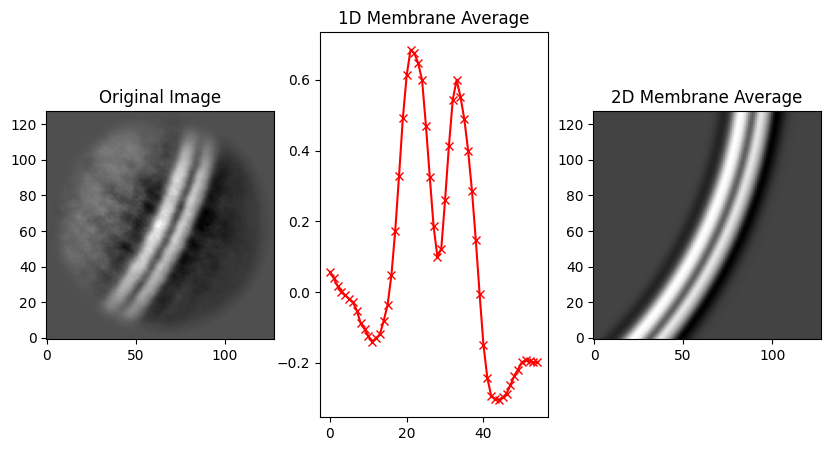

In [12]:
averaged_mem_generator = average_membrane(image=average2D, extra_mem_dist=extra_mem_dist, edge_sigma=edge_sigma, rlnCenterX=rlnCenterX, rlnCenterY=rlnCenterY, rlnAngleTheta=rlnAngleTheta, rlnMembraneDistance=rlnMembraneDistance, rlnSigma1=rlnSigma1, rlnSigma2=rlnSigma2, rlnCurveKappa=rlnCurveKappa)
averaged_mem_generator.calculate_membrane_average()
averaged_membrane = averaged_mem_generator.generate_2d_average_mem()
averaged_mem_generator.visualize_membrane_average()